## In this notebook we will create service area boundaries for each park managed by the city of austin



In [1]:
import geopandas as gpd
import os
import getpass
import matplotlib.pyplot as plt
import re
import pandas as pd

In [36]:
wd = os.getcwd()
wd = wd[:wd.find('notebooks')]


coaparks = gpd.read_file(wd+"data/coaparks/BOUNDARIES_city_of_austin_parks.shp")
coaparks.crs = {'init': 'epsg:102739'}
coaparks
# nature preserves are not for recreation
# Separate these before hand! 
coaparks.head(10)

,ASSET_MGMT,LOCATION_N,ADDRESS,CITY_MUNIC,COUNTY,STATE,STREET_NUM,STREET_NAM,STREET_TYP,ZIPCODE,...,MXPRIORITY,MXLOADID,GLOBALID,CREATED_BY,CREATED_DA,MODIFIED_B,MODIFIED_D,Shape__Are,Shape__Len,geometry
0,412,Stratford Overlook Greenbelt,"3006 Stratford Dr., Austin, Texas 78746",Austin,Travis,TX,3006,Stratford,Dr.,78746,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,4.403262e+03,420.672106,"POLYGON ((3099906.430145308 10076413.89003989,..."
1,413,Highland Neighborhood Park,"403 W St Johns Ave., Austin, Texas 78752",Austin,Travis,TX,403,W St Johns,Ave.,78752,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.048800e+04,422.279483,"POLYGON ((3123253.446115226 10095987.26952823,..."
2,354,Palma Plaza Pocket Park,"1524 Palma Plz., Austin, Texas 78703",Austin,Travis,TX,1524,Palma,Plz,78703,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.007678e+04,492.661534,"POLYGON ((3109560.790101632 10075621.8601279, ..."
3,398,Oertli Neighborhood Park,"12613 Blaine Rd., Austin, Texas 78753",Austin,Travis,TX,12613,Blaine,Rd.,78753,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,2.671883e+05,2404.916487,"POLYGON ((3142167.801987216 10117512.55423348,..."
4,370,Decker Tallgrass Prairie Preserve,"8001 Decker Ln., Austin, Texas 78724",Austin,Travis,TX,8001,Decker,Ln.,78724,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.515843e+07,26672.772067,"POLYGON ((3155053.00948447 10084108.4848869, 3..."
5,394,Oakwood Cemetery,"1012 E 16th St., Austin, Texas 78702",Austin,Travis,TX,1012,E 16th,St,78702,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.712856e+06,5247.929363,"POLYGON ((3118745.25007914 10073911.00003256, ..."
6,364,Peace Point at Town Lake Metro Park,"2200 S Lakeshore Blvd., Austin, Texas 78741",Austin,Travis,TX,2200,S Lakeshore,Blvd,78741,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,2.381281e+05,4343.236948,(POLYGON ((3121502.000143051 10063076.00004905...
7,298,Norwood Tract at Town Lake Metro Park,"1009 Edgecliff Ter., Austin, Texas 78704",Austin,Travis,TX,1009,Edgecliff,Ter,78704,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,4.150892e+05,7283.191248,(POLYGON ((3115397.693454057 10064828.94175315...
8,204,Mayfield Park,"3805 W 35th St., Austin, Texas 78703",Austin,Travis,TX,3805,W 35th,St.,78703,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,1.022823e+06,4794.005509,"POLYGON ((3105648.160459712 10086501.19007523,..."
9,187,Kennemer Pool,"1031 Payton Gin Rd., Austin, Texas 78758",Austin,Travis,TX,1031,Payton Gin,Rd.,78758,...,0,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,4.556303e+04,960.033300,"POLYGON ((3125342.31037581 10104470.85984448, ..."


False

In [40]:
# Creation of buffers of for 1/4 mile (400 meters) and 1/2 a mile (800 meters)

#coaparks_quarter = coaparks.buffer(400)
#coaparks_half = coaparks.buffer(800)

#neighborhood = .5 between 2 and 30 acres
#pocket = .25 <2acres
#district = 1 31 < acres < 200
#greenbelt = 5 look in Names 
#metro = 5  >200 acres 
#schools Look in Names

# series.loc[indexer]
# df.loc[row.indexer, column.indexer]
coaparks_vari = coaparks.copy()
num_neigh = 0
num_pocket = 0
num_district=0
num_greenbelt = 0
num_metro=0
num_schools = 0
num_cem=0

for row in coaparks_vari['ASSET_SIZE'].index:
    if coaparks_vari['ASSET_SIZE'][row] < 2:
        # The record is a pocket park, we buffer by .25 mile
        coaparks_vari['geometry'].loc[row] = coaparks_vari['geometry'].loc[row].buffer(400)
        num_pocket += 1
        
    elif coaparks_vari['ASSET_SIZE'][row] >= 2 and coaparks_vari['ASSET_SIZE'][row] <= 30:
        # The record is a neighborhood park, thus buffer by .5 miles
        coaparks_vari['geometry'].loc[row] = coaparks_vari['geometry'].loc[row].buffer(800)
        num_neigh += 1
    
    elif coaparks_vari['ASSET_SIZE'][row] >= 31 and coaparks_vari['ASSET_SIZE'][row] < 200:
        # This record is a district park
        coaparks_vari['geometry'].loc[row] = coaparks_vari['geometry'].loc[row].buffer(1600)
        num_district += 1
        
    elif coaparks_vari['ASSET_SIZE'][row] >= 200:
        # This record is a metro
        coaparks_vari['geometry'].loc[row] = coaparks_vari['geometry'].loc[row].buffer(8000)
        num_metro += 1
    if 'Greenbelt' in coaparks['LOCATION_N'][row]:
        # We want to make sure we check that all of the greenblets are buffered 
        # by five 
        coaparks_vari['geometry'].loc[row] = coaparks['geometry'].loc[row].buffer(8000)
        num_greenbelt +=1
        
    if 'School' in coaparks['LOCATION_N'][row]:
        # School parks are not buffered, set them back to original poly. 
        coaparks_vari['geometry'].loc[row] = coaparks['geometry'].loc[row]
        num_schools += 1
    if 'Cemetery' in coaparks['LOCATION_N'][row]:
        coaparks_vari['geometry'].loc[row] = coaparks['geometry'].loc[row]
        num_cem +=1
print('pocket', num_pocket)
print('neigh', num_neigh)
print('district', num_district)
print('metro', num_metro)
print('greenbelt', num_greenbelt)
print('school', num_schools)
print('cemetery', num_cem)

pocket 57
neigh 170
district 52
metro 23
greenbelt 50
school 22
cemetery 5


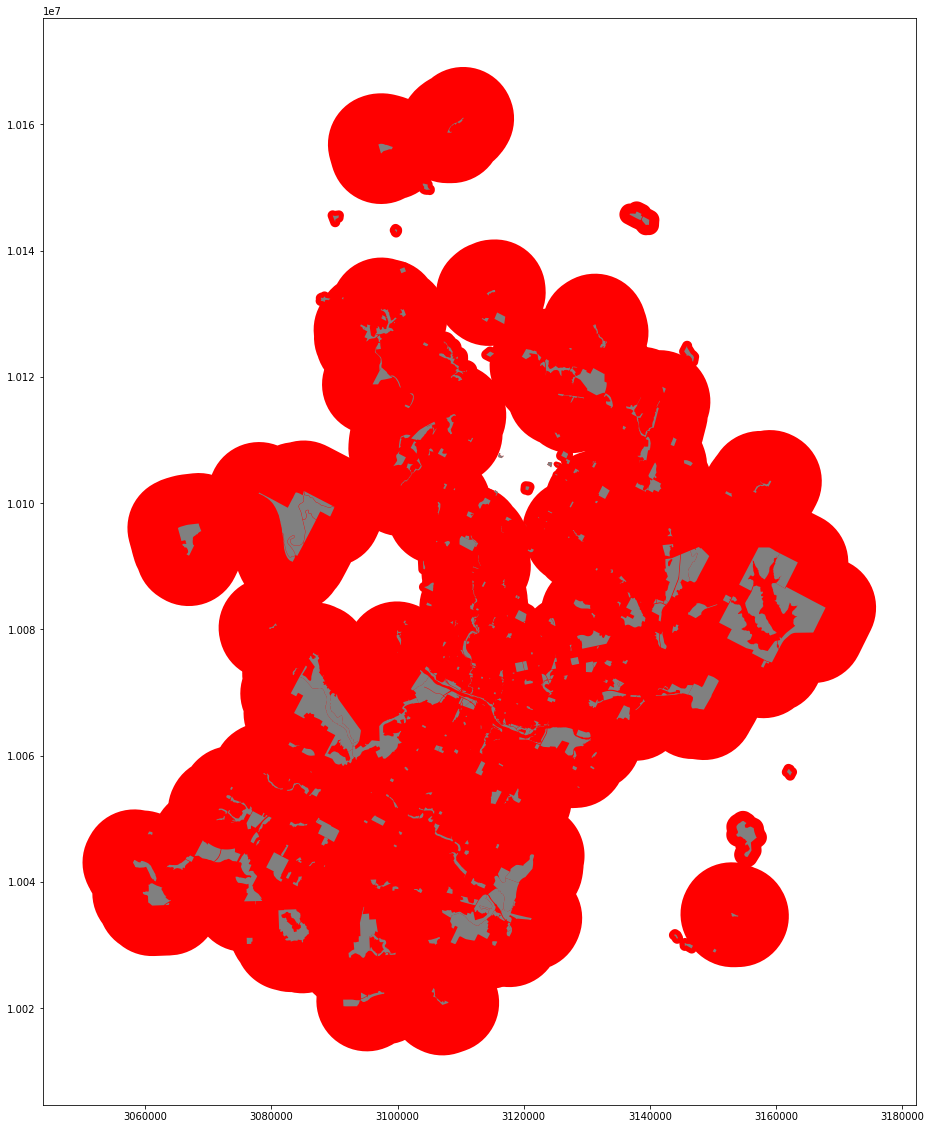

In [39]:
#plot
fig, ax = plt.subplots(figsize=(20,20))
#vastra.plot(ax=ax)
coaparks_vari.plot(ax = ax, color='red')
#coaparks_half.plot(ax=ax, color='blue')
#coaparks_quarter.plot(ax=ax, color='cyan')
coaparks.plot(ax=ax, color='grey');

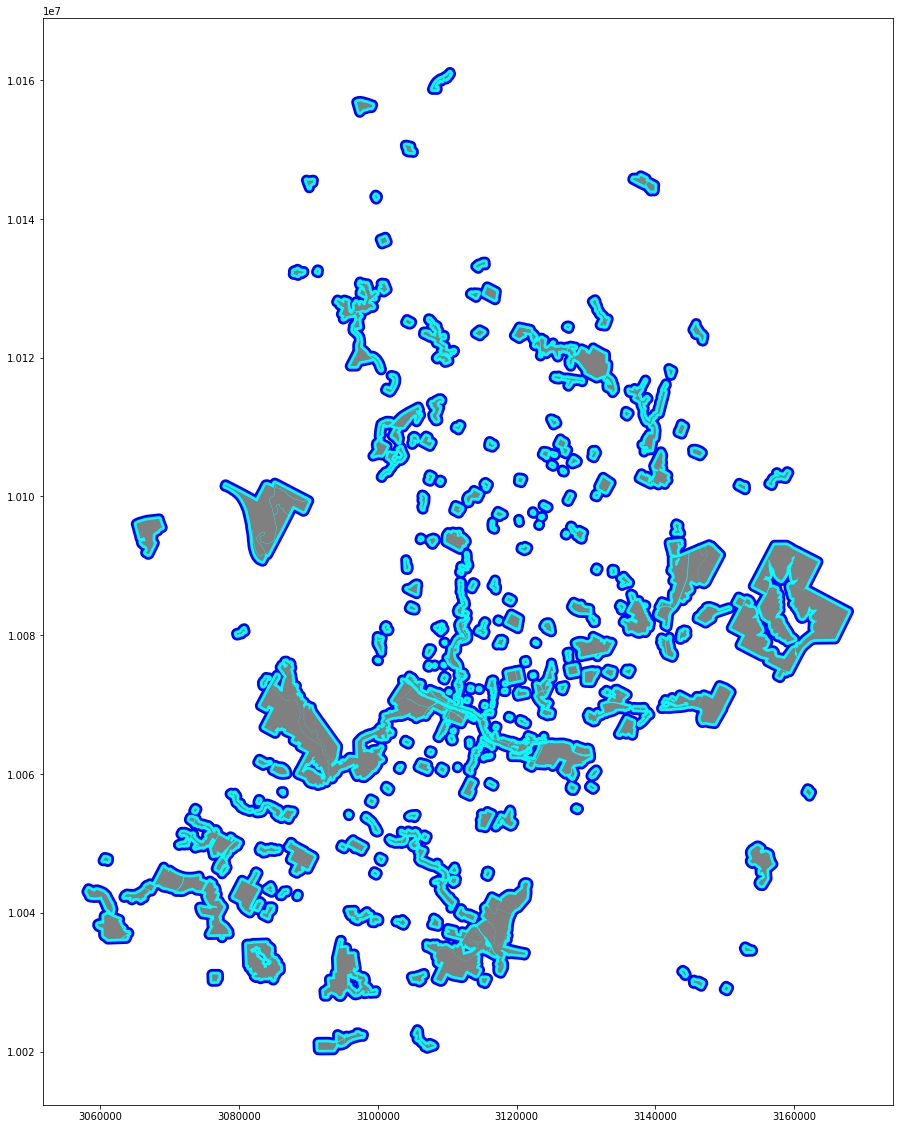

In [14]:
#plot
fig, ax = plt.subplots(figsize=(20,20))
#vastra.plot(ax=ax)
coaparks_half.plot(ax=ax, color='blue')
coaparks_quarter.plot(ax=ax, color='cyan')
coaparks.plot(ax=ax, color='grey');

In [5]:
#to shapefile
coaparks.to_file(wd+"data/coaparks_buffer/parksbuff.shp")
